# Generalized Lotka Volterra: joint estimation (vanilla)

We consider a Generalized Lotka Volterra system with $3$ populations
$$
\frac{\partial}{\partial t}u_i(t) = r_iu_i(t) - \sum_{j\neq i}\alpha_{ij}u_j(t)
-\alpha_{i,i}u_i(t) + c_iu_i(t) + \sum_{j \neq i} c_ju_j(t), i\in\{1, 2, 3\}
$$
In this notebook we jointly estimate the equation solution with a PINN and the equation parameters. To do so we follow the methodology straightforward methodology from _Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations_, Raissi et al., 2019, i.e., we minimize the dynamic loss with respect to both the neural network parameters and the equation parameters. We also make use of a batch of available observations. See more explanation at [this page](https://hgangloff.pages.mia.inra.fr/pinn_experiments/param_estim_pinn.html)

More information on this ODE system can be found at [https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation](https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [3]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

In [4]:
import jinns

/home/hugo/anaconda3/envs/pinn2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

## First we simulate observations (using the true solution)

We use code from Lorenzo Sala

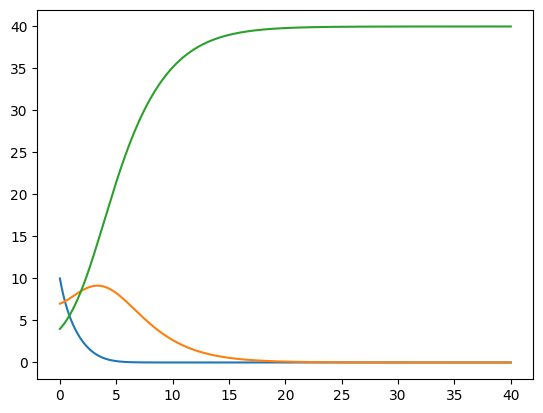

In [6]:
from scipy.integrate import odeint
import numpy as np

def lotka_volterra_log(y_log, t, params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.
    
    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.
        
    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, delta = params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)
    
    for i in range(N):
        dydt[i] = y[i] * (alpha[i] - beta[i] * np.sum(y) - np.sum([gamma[j][i] * y[j] for j in range(N)]))
    
    dydt_log = dydt / y
    
    return dydt_log

# Define name bacteria
names = ['N1', 'N2', 'N3']
N = len(names)

# Define model parameters
growth_rates = [0.1, 0.5, 0.8]#[1., 1., 1.] #  # growth rates
carrying_capacities = [0.04, 0.02, 0.02]#[0., 0., 0.] #  # carrying capacity
interactions = [[0, 0.001, 0.001], [0.001, 0, 0.001], [0.001, 0.001, 0]]#[[10., 9., 5.], [9., 10., 9.], [5., 9., 10.]] #  # interspecies interaction
death_rates = [0.1, 0.02, 0.3]  # death rates
params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4] #[0.26, 0.37, 0.57] #

# Define time points
Tmax = 40
t = np.linspace(0, Tmax, 1000)

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(params,))
y = np.exp(y_log)

for i in range(N): 
    plt.plot(t, y[:,i], label=names[i])

#### (Optionally blur )and select a subsample to define the observations

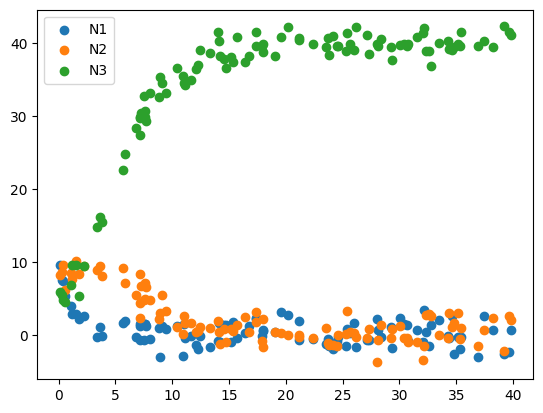

In [7]:
# Optionally blur:
y += np.random.normal(loc=0.0, scale=1.5, size=y.shape)

obs_size = 100
key, subkey = jax.random.split(key)

# random (but small) time step
obs_subsample = jax.random.choice(key, jnp.arange(0, len(t), 1), shape=(obs_size,), replace=False) 
#obs_subsample = jnp.insert(obs_subsample, 1, 0) # make sure X_0 is always in the subsample
obs_subsample = jnp.sort(obs_subsample) # finally we resort on a sorted obs_batch

# fixed time step
# obs_subsample = jnp.linspace(0, size, obs_size, dtype=jnp.int32)[:, None]

# NOTE the division with Tmax
obs_batch = {str(i):(t[obs_subsample] / Tmax, y[obs_subsample, i]) for i in range(N)}

for i in range(N): 
    #plt.plot(t, y[:,i], label=names[i])
    plt.scatter(obs_batch[str(i)][0] * Tmax, obs_batch[str(i)][1], label=names[i])
plt.legend()

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [8]:
eqx_list = [
    [eqx.nn.Linear, 1, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "ODE")

For the record below is the way to create the same network without the utility function

In [9]:
# class MLP(eqx.Module):
#     layers: list

#     def __init__(self, key):
#         key1, key2, key3, key4 = random.split(key, 4)

#         self.layers = [
#             eqx.nn.Linear(1, 20, key=key1),
#             jax.nn.tanh,
#             eqx.nn.Linear(20, 20, key=key2),
#             jax.nn.tanh,
#             eqx.nn.Linear(20, 20, key=key3),
#             jax.nn.tanh,
#             eqx.nn.Linear(20, 1, key=key4),
#             jnp.exp,
#         ]
#     def __call__(self, t):
#         for layer in self.layers:
#             t = layer(t)
#         return t

# def make_mlp(key):
#     mlp = MLP(key) 
#     params, static = eqx.partition(mlp, eqx.is_inexact_array)

#     def init_fn():
#         return params

#     def apply_fn(t, u_params, eq_params=None): # NOTE here the unused eq_params
#         model = eqx.combine(u_params, static)
#         t = t[None] # Note that we added a dimension to t which is laecking for the ODE batches
#         return model(t)[0]

#     return init_fn, apply_fn

Create a DataGenerator object

In [10]:
n = 10000
batch_size = 64
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 50
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

Initialized 3 set of neural network parameters

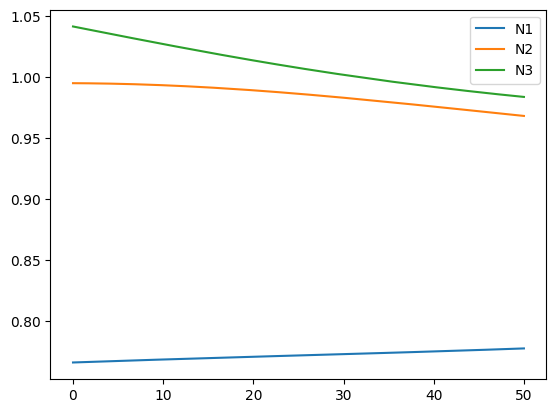

In [11]:
init_nn_params_list = []
for _ in range(3):
    key, subkey = random.split(key)
    init_param_fn, _ = jinns.utils.create_PINN(subkey, eqx_list, "ODE", 0)
    init_nn_params = init_param_fn()
    init_nn_params_list.append(init_nn_params)

vectorized_u_init = vmap(lambda t: u(t, init_nn_params_list[0]), (0), 0)
vectorized_v_init = vmap(lambda t: u(t, init_nn_params_list[1]), (0), 0)
vectorized_w_init = vmap(lambda t: u(t, init_nn_params_list[2]), (0), 0)


plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_u_init(train_data.times.sort(axis=0)), label="N1")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_v_init(train_data.times.sort(axis=0)), label="N2")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_w_init(train_data.times.sort(axis=0)), label="N3")

plt.legend()

## Model parameters
We rewrite the parameters so that it fits our Generalized Lotka Volterra loss (the `interaction` parameters appear in another order)

In [12]:
N_0 = jnp.array([10., 7., 4.])
growth_rates = jnp.array([0.1, 0.5, 0.8])
carrying_capacities = jnp.array([0.04, 0.02, 0.02])
interactions = -jnp.array([[0, 0.001, 0.001], [0, 0.001, 0.001], [0, 0.001, 0.001]])

**(Optionally) Add noise to the initial parameters**

In [13]:
keys = random.split(key, 5)
key = keys[0]
N_0 += random.normal(keys[1], shape=N_0.shape) * 0.1
growth_rates += random.normal(keys[2], shape=growth_rates.shape) * 0.01
carrying_capacities += random.normal(keys[3], shape=carrying_capacities.shape) * 0.01
interactions += random.normal(keys[4], shape=interactions.shape) * 0.01

print(N_0, growth_rates, carrying_capacities, interactions)

[10.079873   6.794454   3.9334898] [0.1046257  0.48725235 0.8047353 ] [0.02399348 0.00518094 0.02360571] [[ 0.02113581 -0.01568821 -0.02428014]
 [ 0.00156198 -0.00218227 -0.006785  ]
 [-0.00327963 -0.0014559  -0.01318252]]


**Note: An important thing to note in the next cell is the `derivative` argument set to `"both"`. This means that we will differentiate the Dynamic Loss both with respect to `nn_params` and `eq_params`.**

In [14]:
N1_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="0", keys_other=["1", "2"], Tmax=Tmax, derivatives="both")
N2_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="1", keys_other=["0", "2"], Tmax=Tmax, derivatives="both")
N3_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="2", keys_other=["0", "1"], Tmax=Tmax, derivatives="both")

In [15]:
# initiate parameters dictionary
init_params = {}

init_params["nn_params"] = {
    str(i): init_nn_params_list[i]
    for i in range(3)
}

init_params["eq_params"] = {
    str(i):{
        "carrying_capacity": carrying_capacities[i],
        "growth_rate": growth_rates[i],
        "interactions": interactions[i, :]
    }
    for i in range(3)
}

In [16]:
loss_weights = {"dyn_loss":1, "initial_condition":1 * Tmax, "observations":1 * Tmax}

loss = jinns.loss.SystemLossODE(
    u_dict={"0":u, "1":u, "2":u},
    loss_weights=loss_weights,
    dynamic_loss_dict={"0":N1_dynamic_loss, "1":N2_dynamic_loss, "2":N3_dynamic_loss},
    initial_condition_dict={"0":(tmin, N_0[0]), "1":(tmin, N_0[1]), "2":(tmin, N_0[2])},
    obs_batch_dict=obs_batch
)

In [17]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 69471.74
Individual losses: {'dyn_loss': '1851.83', 'initial_condition': '128.75', 'observations': '1223.65'}


## Joint estimation
We want to update both `nn_params` and `eq_params`

In [18]:
params = init_params

In [19]:
# Optimizer
import optax
from jaxopt import OptaxSolver

--> (Currently not done) We could start with some iteration of `nn_params` only

--> Optimize on both sets of parameters directly

In [20]:
n_iter = int(100000)

Here we alternate between optimizing `nn_params` and `eq_params` by using "opposite schedulers" in `optax`. We provide a utility function alternate_optax_solver which performs the alternating optimization.

In [21]:
# steps at which learning alternates between the two sets of params (excluding step 0 !)
steps = np.arange(1000, n_iter, 1000) # NOTE this is a numpy array !
tx = jinns.utils.alternate_optax_solver(
    steps,
    list(params['nn_params'].keys()), # we need to give leaf-level keys
    ["growth_rate", "carrying_capacity", "interactions"],
    1e-3, # nn_params lr
    1e-5 # eq_params lr
)

Next consists in classical initializations

In [22]:
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output
                     maxiter=500000)

pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter
)

Next we defined which parameter we want to track

In [23]:
accu_vars = [
    ['eq_params', '0', 'growth_rate'], ['eq_params', '0', 'carrying_capacity'], ['eq_params', '0', 'interactions', 0],
    ['eq_params', '1', 'growth_rate'], ['eq_params', '1', 'carrying_capacity'], ['eq_params', '1', 'interactions', 0],
    ['eq_params', '2', 'growth_rate'], ['eq_params', '2', 'carrying_capacity'], ['eq_params', '2', 'interactions', 0]
]

Then the optimization starts

In [24]:
params, total_loss_list, loss_by_term_dict, _, accu_vars_params = pinn_solver.solve(
    init_params=params,
    data=train_data,
    accu_vars=accu_vars,
    seq2seq=None,
)

Running for 100,000 iterations: 100%|██| 100000/100000 [02:55<00:00, 569.12it/s]


## Results

Plot the tracked parameters

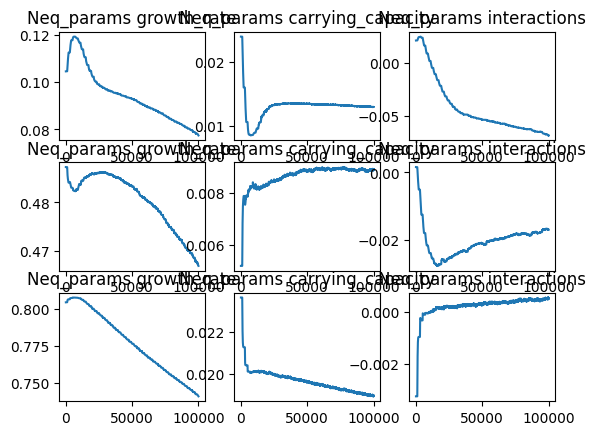

{'eq_params-0-carrying_capacity': Array([0.02399348, 0.02399348, 0.02399348, ..., 0.01293728, 0.01293798,
       0.012939  ], dtype=float32), 'eq_params-0-growth_rate': Array([0.1046257 , 0.1046257 , 0.1046257 , ..., 0.0774698 , 0.07746768,
       0.07746521], dtype=float32), 'eq_params-0-interactions-0': Array([ 0.02113581,  0.02113581,  0.02113581, ..., -0.0685105 ,
       -0.06851158, -0.06851189], dtype=float32), 'eq_params-1-carrying_capacity': Array([0.00518094, 0.00518094, 0.00518094, ..., 0.0089151 , 0.00891686,
       0.00891799], dtype=float32), 'eq_params-1-growth_rate': Array([0.48725235, 0.48725235, 0.48725235, ..., 0.4669613 , 0.46695805,
       0.4669555 ], dtype=float32), 'eq_params-1-interactions-0': Array([ 0.00156198,  0.00156198,  0.00156198, ..., -0.01691796,
       -0.01692259, -0.01692685], dtype=float32), 'eq_params-2-carrying_capacity': Array([0.02360571, 0.02360571, 0.02360571, ..., 0.01899054, 0.01898936,
       0.01898701], dtype=float32), 'eq_params-2-growt

In [25]:
fig, axes = plt.subplots(3, 3)

colors = ['green', 'orange', 'blue']
for idx, params_leaf_path in enumerate(accu_vars):
    i = idx // 3
    j = idx % 3
    axes[i, j].plot(accu_vars_params['-'.join(map(str, params_leaf_path))])
    axes[i, j].set_title(f"N{params_leaf_path[0]} {params_leaf_path[2]}")
plt.show()
print(accu_vars_params)

Plot the losses

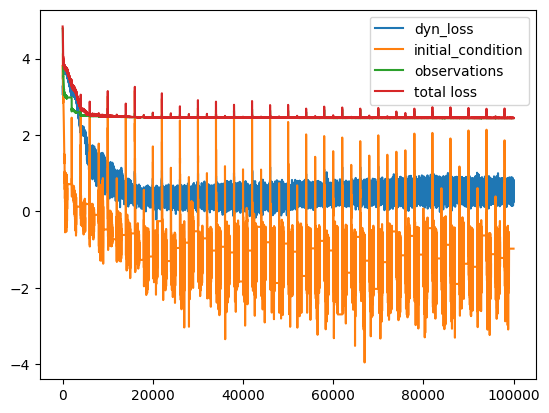

In [26]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Plot the estimated solution

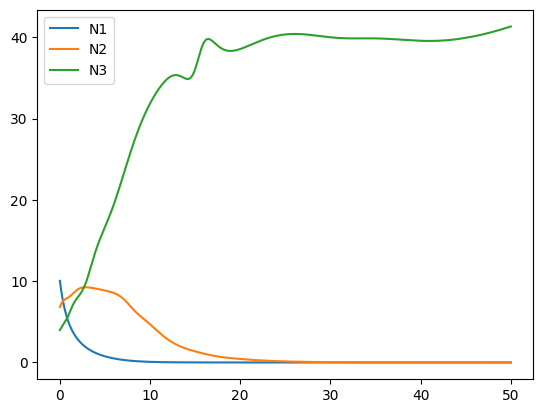

In [28]:
u_est_fp = vmap(lambda t:u(t, params["nn_params"]["0"], None), (0), 0)
v_est_fp = vmap(lambda t:u(t, params["nn_params"]["1"], None), (0), 0)
w_est_fp = vmap(lambda t:u(t, params["nn_params"]["2"], None), (0), 0)

key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

plt.plot(val_data.times.sort(axis=0) * Tmax, u_est_fp(val_data.times.sort(axis=0)), label="N1")
plt.plot(val_data.times.sort(axis=0) * Tmax, v_est_fp(val_data.times.sort(axis=0)), label="N2")
plt.plot(val_data.times.sort(axis=0) * Tmax, w_est_fp(val_data.times.sort(axis=0)), label="N3")

plt.legend()

Compute the MSE with respect to scipy's solution

In [29]:
mse_u = jnp.mean((u_est_fp(val_data.times.sort(axis=0))[obs_subsample] - y[obs_subsample, 0]) ** 2)
mse_v = jnp.mean((v_est_fp(val_data.times.sort(axis=0))[obs_subsample] - y[obs_subsample, 1]) ** 2)
mse_w = jnp.mean((w_est_fp(val_data.times.sort(axis=0))[obs_subsample] - y[obs_subsample, 2]) ** 2)
print(mse_u, mse_v, mse_w)

10.766516 56.68273 674.7957
